<a href="https://colab.research.google.com/github/Nina-Om/ArcGIS-MapBook-Toolbox/blob/master/2_LCRB_Analog_streamflow_prediction_BOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run predictive kNN model for analog based monsoon streamflow prediction in LCRB

**Title**: k-Nearest Neighbors (kNN) Analysis for Identifying Analog Years and Streamflow Prediction \
**Author**: Nina Omani \
**Date created**: 2/14/2024  \
\
**Description**:  \
This notebook uses the k-Nearest Neighbors (kNN) algorithm to identify analog years based on hydroclimate condition and streamflow data.

It standardizes hydroclimate features, performs kNN to find the 4 closest analog years, and calculates streamflow predictions.

The script then evaluates the predictive performance using metrics such as MAE, RMSE, and MAPE, and visualizes the results.

**Requirements:** \
The script requires the following input files:
*   **2.WT_combined_data.csv**: Output from the **1.WT_File_gather.R** script, containing weather type data with streamflow information.
*   **BOR Intervening Flows Data 1971-2022_NFDextension v2.xlsx**: Streamflow observation data.

**Hindcast WTs:** 1981-2023 \
**Available Historic WTs:** 1970-2023 \
**Streamflow:** 1972-2022 \
**Evaluation period:** 1993-2021


Ensure these files are present and paths are correctly set.



# Runtime setup:
To activate the R kernel in Google Colab, follow these steps:, make sure you select "R" Runtime type under "Runtime", "Change runtime type", Runtime type:R.

# **Experiments**

**SMYLE vs. ECMWF Comparisons** \
`ECMWF <- TRUE `  
 Determines whether the experiment uses ECMWF data (TRUE) or SMYLE data (FALSE).

**Baseline Experiment or Default Conditions (Figure 3, 12)** \
Assess the baseline scenario without antecedent streamflow and WTs predictors.

Conditions: \
`ECMWF: TRUE`         - Indicates the experiment uses ECMWF data. \
`feature: baseline`      - No antecedent streamflow or WTs predictors are included. \
`AGGREGATE: FALSE`    - Monthly WTs predictors are used, not aggregated predictors (e.g., JJASO, JASO).
```
combinations <- data.frame(
  region = c("AZ_West", "AZ_West"),
  gage = c("Glen_Hoover", "Total_Below_Parker")
)
```
**Regional weather impact assessment (Figure 8)** \
Assess regional weather impact without antecedent predictors or aggregated WTs.

Conditions: \
`feature <- baseline`  Does not include antecedent predictors \
`AGGREGATE <- FALSE `  Does not use aggregated WTs predictors
```
combinations <- data.frame(
  region = c("AZ_East", "AZ_West"),
  gage = c("Glen_Hoover", "Glen_Hoover")
)
```
**Aggregated WTs as Predictors (Figure 9)** \
Similar to the baseline but with aggregated WTs predictors.

Conditions: \
`feature <- baseline`     - No antecedent streamflow predictors included. \
`AGGREGATE <- TRUE `   - Aggregated WTs predictors (e.g., JJASO, JASO, ASO)
```
combinations <- data.frame(
  region = c("AZ_West", "AZ_West"),
  gage = c("Glen_Hoover", "Total_Below_Parker")
)
```
**Influence of initial conditions (Figure 10)** \
Examine the impact of including antecedent streamflow as a predictor.

Conditions: \
`feature <- anteced_streamflow_features`     - Includes antecedent streamflow as a predictor \
`AGGREGATE <- FALSE `       - Uses monthly WTs predictors, not aggregated ones.
```
combinations <- data.frame(
  region = c("AZ_West", "AZ_West"),
  gage = c("Glen_Hoover", "Total_Below_Parker")
)
```
**TCLW variable as predictor + initial conditions (Figure 10)** \
Conditions: \
`feature <- anteced_streamflow_features`  \
`predictors <- c("tclw")`
```
combinations <- data.frame(
  region = c("AZ_West", "AZ_West"),
  gage = c("Glen_Hoover", "Total_Below_Parker")
)
```
**Q850 and TCLW as a predictor directly (Figure 11)** \
Conditions: \
Baseline conditions : \
 `feature <- baseline`  \
`predictors <- c("q") or c("tclw")`


#FNN package
**get.knnx function:**
  
It is designed to find the k-nearest neighbors of a set of query points in a given dataset.

It takes two main input matrices: data (the dataset in which to search for neighbors) and query (the points for which neighbors are found).

This function is useful when you have a specific set of points outside your dataset for which you want to find neighbors within your dataset.


In [ ]:
#Install the packages if required
if (!requireNamespace("readr", quietly = TRUE)) install.packages("readr")
if (!requireNamespace("FNN", quietly = TRUE)) install.packages("FNN")
if (!requireNamespace("zoo", quietly = TRUE)) install.packages("zoo")
if (!requireNamespace("reshape2", quietly = TRUE)) install.packages("reshape2")
if (!requireNamespace("Metrics", quietly = TRUE)) install.packages("Metrics")
if (!requireNamespace("readxl", quietly = TRUE)) install.packages("readxl")
if (!requireNamespace("tidyr", quietly = TRUE)) install.packages("tidyr")
if (!requireNamespace("tibble", quietly = TRUE)) install.packages("tibble")
if (!requireNamespace("dplyr", quietly = TRUE)) install.packages("dplyr")
if (!requireNamespace("ggplot2", quietly = TRUE)) install.packages("ggplot2")
if (!requireNamespace("grid", quietly = TRUE)) install.packages("grid")
if (!requireNamespace("gridExtra", quietly = TRUE)) install.packages("gridExtra")
if (!requireNamespace("reticulate", quietly = TRUE)) install.packages("reticulate")
if (!requireNamespace("googledrive", quietly = TRUE)) install.packages("googledrive")
if (!requireNamespace("plotly", quietly = TRUE)) install.packages("plotly")

In [ ]:
library(FNN)
library(readr)
library(dplyr)
library(tibble)
library(ggplot2)
library(readxl)
library(zoo)
library(reshape2)
library(tidyr)
library(Metrics)
library(grid)
library(gridExtra)
library(googledrive)
library(reticulate)

In [ ]:
# Execute Python code to mount Google Drive using system
system("python3 -c 'from google.colab import drive; drive.mount(\"/content/drive\")'")

# Functions (0.Functions.R)

In [ ]:
# Function definitions

standardize <- function(x) {
  (x - mean(x, na.rm = TRUE)) / sd(x, na.rm = TRUE)}

# Filter and prepare historic and forecast data for the kNN analysis.
prepare_data <- function(data, years, months, obs = TRUE) {
  # Select columns based on whether preparing observed (obs) or forecasted (for) data
  select_cols <- if (obs) c("Year", "Month", grep("_obs$|.obs$", names(data), value = TRUE)) else c("lead_date", "lead_month", "Year", "Month", grep("_for$|.for$", names(data), value = TRUE))

  prepared_data <- data %>%
    filter(Year %in% years, Month %in% months) %>%
    select(all_of(select_cols)) %>%
    na.omit() %>%
    distinct()

  prepared_data <- prepared_data %>%
    mutate(across(everything(), as.numeric))

  return(prepared_data)
}

# Conduct initial data exploration, including correlation analysis and plotting of monthly means.
perform_data_exploration <- function(data) {
  # Correlation analysis
  cor_matrix_for <- cor(data %>% select(dry.for, normal.for, monsoon.for), use = "complete.obs")
  #print(cor_matrix_for)

  cor_matrix_obs <- cor(data %>% select(dry.obs, normal.obs, monsoon.obs), use = "complete.obs")
  #print(cor_matrix_obs)

  # Plotting mean monthly values
  monthly_means <- data %>%
    group_by(Month) %>%
    summarise(
      mean_dry_obs = mean(dry.obs, na.rm = TRUE),
      mean_normal_obs = mean(normal.obs, na.rm = TRUE),
      mean_monsoon_obs = mean(monsoon.obs, na.rm = TRUE)
    ) %>%
    ungroup()

  ggplot(monthly_means, aes(x = Month)) +
    geom_line(aes(y = mean_dry_obs, color = "Dry"), linewidth = 1) +
    geom_line(aes(y = mean_normal_obs, color = "Normal"), linewidth = 1) +
    geom_line(aes(y = mean_monsoon_obs, color = "Monsoon"), linewidth = 1) +
    scale_color_manual(values = c("Dry" = "red", "Normal" = "green", "Monsoon" = "blue")) +
    labs(title = "Mean Monthly Observations", x = "Month", y = "Mean Observation Value", color = "Observation Type") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
}

# AntecedentMeans <- function(data, n) {
#   if(n == 1) {
#     return(c(NA, head(data, -1)))
#   } else {
#     antecedent_means <- rep(NA, length(data))
#     for(i in (n+1):length(data)) {
#       antecedent_means[i] <- mean(data[(i-n):(i-1)], na.rm = TRUE)
#     }
#     return(antecedent_means)
#   }
# }

AntecedentMeans <- function(data, n) {
  # Initialize a vector to store the antecedent means
  antecedent_means <- rep(NA, length(data))

  if (n < 1) {
    stop("n must be greater than or equal to 1")
  }

  if (n == 1) {
    antecedent_means[2:length(data)] <- head(data, -1)
  } else {
    for (i in (n + 1):length(data)) {
      antecedent_means[i] <- mean(data[(i - n):(i - 1)], na.rm = TRUE)
    }
  }
  return(antecedent_means)
}

#antecedent_monthly <- AntecedentMeans(monthly_data, 1)
#antecedent_mean_two_months <- AntecedentMeans(monthly_data, 2)
#antecedent_mean_three_months <- AntecedentMeans(monthly_data, 3)

# Function to perform kNN and find analogs, appending results to a dataframe (more features)
find_analogs_for_month_and_lead <- function(historic_data, forecast_data, month, lead_month, k) {

  results_df <- data.frame()

  # For each entry in forecast_data, filter out the matching year in historic_data
  for (i in seq_len(nrow(forecast_data))) {
    forecast_row <- forecast_data[i, ]

    if (forecast_row$Month == month && forecast_row$lead_month == lead_month) {
      # Exclude the forecast year from the historic data
      historic_filtered <- na.omit(historic_data[historic_data$Month == month & historic_data$Year != forecast_row$Year, ])

      obs_cols_historic <- grep("_obs$", names(historic_filtered), value = TRUE)
      if (!all(sapply(historic_filtered[, obs_cols_historic], is.numeric))) {
        stop("Non-numeric data found in historic_filtered.")
      }

      # Prepare the matrices for kNN
      historic_matrix <- historic_filtered %>%
        select(contains("_obs")) %>%
        data.matrix()

      forecast_matrix <- forecast_row %>%
        dplyr::select(contains("_for")) %>%
        data.matrix()

      if (ncol(historic_matrix) != ncol(forecast_matrix)) {
        stop("Number of features in historic and forecast data does not match.")
      }

      # Perform kNN
      knn_result <- get.knnx(historic_matrix, forecast_matrix, k = k)

      # Normalize weights for the current forecast row
      analog_distances <- knn_result$nn.dist[1, ]
      analog_weights <- 1 / (analog_distances + 1e-5)

      # Calculate distances and weights for the current forecast's analogs
      for (j in 1:k) {
        analog_year <- historic_filtered$Year[knn_result$nn.index[1, j]]
        results_df <- rbind(results_df, data.frame(
          ForecastYear = forecast_row$Year,
          Month = month,
          LeadMonth = lead_month,
          AnalogYear = analog_year,
          Distance = analog_distances[j],
          Weight = analog_weights[j],
          Rank = j))
      }
    }
  }

  return(results_df)
}

find_analogs_for_season_and_lead <- function(historic_data, forecast_data, month, season, lead_month, k) {

  results_df <- data.frame()

  # Loop through each row of forecast data
  for (i in seq_len(nrow(forecast_data))) {
    forecast_row <- forecast_data[i, ]

    if (forecast_row$Month == month && forecast_row$lead_month == lead_month) {
      # Exclude the forecast year from the historic data
      historic_filtered <- na.omit(historic_data[historic_data$Month == month & historic_data$Year != forecast_row$Year, ])

      obs_cols_historic <- grep("_obs$", names(historic_filtered), value = TRUE)
      if (!all(sapply(historic_filtered[, obs_cols_historic], is.numeric))) {
        stop("Non-numeric data found in historic_filtered.")
      }

      # Prepare the matrices for kNN
      historic_matrix <- historic_filtered %>%
        select(contains("sd")) %>%
        select(-c("sd_dry_obs", "sd_normal_obs", "sd_monsoon_obs")) %>%  # Keep only aggregated data
        data.matrix()

      forecast_matrix <- forecast_row %>%
        select(contains("sd")) %>%
        select(-c("sd_dry_for", "sd_normal_for", "sd_monsoon_for")) %>%  # Keep only aggregated data
        data.matrix()

      if (ncol(historic_matrix) != ncol(forecast_matrix)) {
        stop("Number of features in historic and forecast data does not match.")
      }

      # Perform kNN
      knn_result <- get.knnx(historic_matrix, forecast_matrix, k = k)

      # Loop through each forecast to extract and store results
      analog_distances <- knn_result$nn.dist[1, ]
      analog_weights <- 1 / (analog_distances + 1e-5)

      for (j in 1:k) {
        analog_year <- historic_filtered$Year[knn_result$nn.index[1, j]]
        results_df <- rbind(results_df, data.frame(
          ForecastYear = forecast_row$Year,
          Month = month,
          Season = season,
          LeadMonth = lead_month,
          AnalogYear = analog_year,
          Distance = analog_distances[j],
          Weight = analog_weights[j],
          Rank = j))
      }
    }
  }

  return(results_df)
}

#The function mape calculates the Mean Absolute Percentage Error (MAPE)
mape <- function(actual, predicted) {
  mean(abs((actual - predicted) / actual), na.rm = TRUE) * 100
}

# **Step 1: Configurtions**

**Define K: K is the number of nearest neighbors in kNN or the number of analog years used in the analysis.**

In [ ]:
K = 10

**Define Hindcast and Historic(Reanalysis) Data Period for kNN analog search**

In [ ]:
  forecast_years <- 1981:2023  #1981:2023 #1993:2021
  historic_years <- 1985:2023   #1970:2023 increases forecast skill #1982:2018 decreases forecast skill

**Select the model SMYLE or ECMWF and upload reanalysis/hindcast WTs and streamflow data**

In [ ]:
ECMWF <- T  #If FALSE, it uploades SMYLE data

if (ECMWF) {
  model_dir <- "ECMWF"
  if (!dir.exists(model_dir)) {
    dir.create(model_dir)
  }
  system("gdown '1GMrN8ynFg0hDkf8MYmmrHauehzQkCmRa' -O /content/ECMWF/2.WT_combined_data.csv")
 } else {
  model_dir <- "SMYLE"

  if (!dir.exists(model_dir)) {
    dir.create(model_dir)
  }
  system("gdown '1mcSZZ2UCyRYjrse-P_cOGX920aj6nXDY' -O /content/SMYLE/2.WT_combined_data.csv")
}

**Define the predictor variables**

In [ ]:
clim_vars <- c("q", "tclw", "tcwv")

# Options: "WT", or any combination of "q", "tclw", "tcwv"
#predictors <- ""
predictors <- c("tclw")
#predictors <- c("q")
#predictors <- c("tcwv")
#predictors <- c("WT")


**Select the anecedent variables as a predictors** \
Currently, the best scenario is antecedent streamflow as predictor

In [ ]:
##Features list: WTs and climate variable never appear together in predictors pool

#feature <- "anteced_WT_features"           #adding antecedent WTs to the monthly WTs predictors
feature <- "anteced_streamflow_features"   #adding antecedent streamflow to the "Baseline"
#feature <- "all_features"                  #adding both antecedent WTs and streamflow to the monthly WTs predictors
#feature <- "baseline"                      #Baseline (monthly WTs or monthly climate variable predictor)


**Select region of interest to pull atmospheric variables** \
Currenly, the best scenario is AZ_West

In [ ]:
# Select WTs region and interested gage or Resevoir/Dam name.
combinations <- data.frame(
  region = c("AZ_West", "AZ_West"),  #region : "AZ_East", "AZ_West"
  gage = c("Glen_Hoover", "Total_Below_Parker")  #gages: Total_Below_Parker, Glen_Hoover
)

**Determine if including the aggregated months (seasonal) WTs as predictor** \
Currently, the best scenario is single monthly WTs predictor

In [ ]:
AGGREGATE <- F # If TRUE, Seasonal or aggregated WT will be used as a predictor, the default is FALSE.

if (any(predictors %in% clim_vars) || predictors == "") {
  AGGREGATE <- FALSE
  predictors <- predictors[!predictors %in% 'WT']
  message("AGGREGATE set to FALSE. WT has been dropped from predictors as predictors are either in clim_vars or empty.")
} else if (AGGREGATE) {
  # If AGGREGATE is TRUE, set the predictors to 'WT'
  predictors <- c('WT')
} else {
  message("No changes made to predictors as AGGREGATE is FALSE and WT is not in predictors.")
}


AGGREGATE set to FALSE. WT has been dropped from predictors as predictors are either in clim_vars or empty.



## Download input data

**Weather Type data**

In [ ]:
# List files in your Google Drive
list.files('/content/')

[1] "5_combined_forecast_variables.csv"                   
[2] "BORInterveningFlowsData1971-2022_NFDextensionv2.xlsx"
[3] "ECMWF"                                               
[4] "ERA_q_regional.csv"                                  
[5] "ERA_tclw_regional.csv"                               
[6] "ERA_tcwv_regional.csv"                               
[7] "sample_data"                                         
[8] "SMYLE"

In [ ]:
weather_data <- read.csv(paste0("/content/", model_dir,'/', '2.WT_combined_data.csv'))
print(head(weather_data))

  YYYYMM dry.obs normal.obs monsoon.obs Year Month  region lead_date dry.for
1 197006      26          4           0 1970     6 AZ_East        NA      NA
2 197007       1         19          11 1970     7 AZ_East        NA      NA
3 197008       0         13          18 1970     8 AZ_East        NA      NA
4 197009      17         12           1 1970     9 AZ_East        NA      NA
5 197010      28          3           0 1970    10 AZ_East        NA      NA
6 197106      30          0           0 1971     6 AZ_East        NA      NA
  normal.for monsoon.for lead_month
1         NA          NA         NA
2         NA          NA         NA
3         NA          NA         NA
4         NA          NA         NA
5         NA          NA         NA
6         NA          NA         NA


**Download streamflow data**

In [ ]:
system("gdown 'https://drive.google.com/uc?id=1jvLtMe7mWoG6KO9fm5tmeDeH3wJxTvY_' -O /content/BORInterveningFlowsData1971-2022_NFDextensionv2.xlsx")

In [ ]:
streamflow_data_obs <- read_excel("/content/BORInterveningFlowsData1971-2022_NFDextensionv2.xlsx", sheet = "Summary Data")
print(head(streamflow_data_obs))

# A tibble: 6 × 7
  Date                Month  Year Glen_Hoover Parker_Imperial Imperial_Mex
  <dttm>              <dbl> <dbl>       <dbl>           <dbl>        <dbl>
1 1971-01-31 00:00:00     1  1971       96442          -13020           NA
2 1971-02-28 00:00:00     2  1971      -16241          -48473           NA
3 1971-03-31 00:00:00     3  1971        5506          -60375           NA
4 1971-04-30 00:00:00     4  1971      -25691           -7702           NA
5 1971-05-31 00:00:00     5  1971       49182          -27342           NA
6 1971-06-30 00:00:00     6  1971       21035          -46618           NA
# ℹ 1 more variable: Total_Below_Parker <dbl>


**Download ECMWF forecasted and ERA5.1 reanalysis**

In [ ]:
 # Define the climate variables
  clim_vars <- c("q", "tclw", "tcwv")

  if (any(predictors %in% clim_vars)) {
    # Read and process the forecast variables
    system("gdown 'https://drive.google.com/uc?id=10g9FyL6ongiESzuADnRrVi4WwFea-GZi' -O /content/5_combined_forecast_variables.csv")
    forecast_var <- read_csv("/content/5_combined_forecast_variables.csv", show_col_types = FALSE)
    forecast_var <- rename(forecast_var, lead_month = init_Month)
    forecast_var$lead_month <- as.numeric(forecast_var$lead_month)
    forecast_var <- rename(forecast_var, region = Region)

    # Download ERA reanalysis climate variables
    system("gdown 'https://drive.google.com/uc?id=1keSg1hFPEVQxWyqS4ONEDNs-aaIlGFte' -O /content/ERA_tclw_regional.csv")  # tclw
    system("gdown 'https://drive.google.com/uc?id=1-DqN4uIILKEmZ0jk7jSIg4LLeZ-vhO5o' -O /content/ERA_q_regional.csv")    # q
    system("gdown 'https://drive.google.com/uc?id=1opBJp6hieUF9vvxfpSnSFZqMp1LXjUM0' -O /content/ERA_tcwv_regional.csv")  # tcwv

    # Ensure weather_data's lead_month is also numeric
    if ("lead_month" %in% names(weather_data)) {
      weather_data$lead_month <- as.numeric(weather_data$lead_month)
    }

    # Process each predictor dynamically, excluding "WT"
    for (pred in predictors) {
      if (pred != "WT") {

        file_path <- paste0("/content/ERA_", pred, "_regional.csv")
        if (file.exists(file_path)) {
          era_data <- read_csv(file_path, show_col_types = FALSE)
          era_data <- rename(era_data, region = Region)

          # Merge ERA data with weather data for observations
          weather_data <- left_join(weather_data, era_data[, c("Year", "Month", "region", pred)], by = c("Year", "Month", "region"))

          # Rename observation columns dynamically only if it doesn't already exist
          var_obs <- paste0(pred, "_obs")
          if (!(var_obs %in% names(weather_data))) {
            weather_data <- rename(weather_data, !!var_obs := all_of(pred))
          }

          # Merge with forecast data
          weather_data <- left_join(weather_data, forecast_var[, c("Year", "Month", "region", "lead_month", pred)], by = c("Year", "Month", "region", "lead_month"))

          # Rename forecast columns dynamically only if it doesn't already exist
          var_for <- paste0(pred, "_for")
          if (!(var_for %in% names(weather_data))) {
            weather_data <- rename(weather_data, !!var_for := all_of(pred))
          }
        } else {
          message(paste("Warning: File not found:", file_path))
        }
      }
    }
  }

processed_weather_data <- weather_data

# **Step 2: Data preparation for kNN analysis**

Target year period and search pool length should be defined in Step1, below function. Currently, they are: \
  forecast_years : 1981:2023  \
  historic_years :  1970:2023  \

In [ ]:
# Function to standardize data by Month and lead_month

# Standardize weather type
 baseline <- processed_weather_data %>%
   group_by(region) %>%
   mutate(
     sd_dry_for = ifelse(is.na(dry.for), NA, standardize(dry.for)),
     sd_normal_for = ifelse(is.na(normal.for), NA, standardize(normal.for)),
     sd_monsoon_for = ifelse(is.na(monsoon.for), NA, standardize(monsoon.for)),
     sd_dry_obs = ifelse(is.na(dry.obs), NA, standardize(dry.obs)),
     sd_normal_obs = ifelse(is.na(normal.obs), NA, standardize(normal.obs)),
     sd_monsoon_obs = ifelse(is.na(monsoon.obs), NA, standardize(monsoon.obs))
   ) %>%
  ungroup()

# Remove any NULL columns that were added due to non-existent variables
baseline <- baseline %>%
  select_if(~ !is.null(.))
##############################################################################################
# Step 2: Add antecedent WT features after standardizing
conditions <- c("sd_dry", "sd_normal", "sd_monsoon")
suffixes <- c("for", "obs")

anteced_WT_features <- baseline

for (condition in conditions) {
  for (suffix in suffixes) {
    for (n in 1:3) {
      column_name <- paste("ant", condition, n, "mean_m", suffix, sep = "_")
      original_column_name <- paste(condition, suffix, sep = "_")

      # Apply the AntecedentMeans function to each condition and suffix combination
      if (original_column_name %in% names(anteced_WT_features)) {
        anteced_WT_features <- anteced_WT_features %>%
          group_by(region, Month, lead_month) %>%  # Group by region, month, and lead month
          mutate(!!sym(column_name) := AntecedentMeans(get(original_column_name), n)) %>%
          ungroup()
      }
    }
  }
}

#############################################################################################
if (any(predictors %in% clim_vars)) {
  # Create a copy of the original data frame
  climvar_st_features <- processed_weather_data

  # Step 1: Prepare the list of columns to standardize
  new_cols <- c()  # Initialize a vector to store the names of columns to standardize

  for (pred in predictors) {
    obs_col <- paste0(pred, "_obs")
    for_col <- paste0(pred, "_for")

    # Directly add the columns to standardize
    new_cols <- c(new_cols, obs_col, for_col)
  }

  # Step 2: Standardize the specified columns by Month and Region
  climvar_st_features <- climvar_st_features %>%
    group_by(Month, region) %>%  # Group by Month and Region
    mutate(
      across(all_of(new_cols), ~ ifelse(is.na(.), NA, standardize(.)), .names = "sd_{col}")
    ) %>%
    ungroup()  # Remove grouping

  # Update baseline with standardized climate variable features
  baseline <- climvar_st_features
}

baseline <- baseline %>%
  select_if(~ !is.null(.))
###############################################################################################
# Streamflow data processing
new_names <- c("Glen_Hoover", "Parker_Imperial", "Imperial_Mex", "Total_Below_Parker")

# Reshape the streamflow data to a long format
streamflow_data_long <- streamflow_data_obs %>%
  pivot_longer(
    cols = all_of(new_names),
    names_to = "Gage",
    values_to = "Observation"
  )

# Group by Gage for standardization
streamflow_features <- streamflow_data_long %>%
  group_by(Gage) %>%  # Group by Gage and Month
  mutate(
    # Apply standardization to antecedent mean flows
    ant_sd_flow_mean_1_obs = standardize(AntecedentMeans(Observation, 1)),
    ant_sd_flow_mean_2_obs = standardize(AntecedentMeans(Observation, 2)),
    ant_sd_flow_mean_3_obs = standardize(AntecedentMeans(Observation, 3)),
    ant_sd_flow_mean_1_for = standardize(AntecedentMeans(Observation, 1)),
    ant_sd_flow_mean_2_for = standardize(AntecedentMeans(Observation, 2)),
    ant_sd_flow_mean_3_for = standardize(AntecedentMeans(Observation, 3))
  ) %>%
  ungroup()  # Remove the grouping after standardization

In [ ]:
# prepare_predictors <- function(baseline, streamflow_features, anteced_WT_features, region, gage, predictors) {

#   baseline_reg <- baseline[baseline$region == region, ]
#   baseline_reg <- as.data.frame(baseline_reg)
#   anteced_WT_features_reg <- anteced_WT_features[anteced_WT_features$region == region, ]
#   anteced_WT_features_reg <- as.data.frame(anteced_WT_features_reg)

#   streamflow_features_gage <- streamflow_features[streamflow_features$Gage == gage, ]
#   streamflow_features_gage <- as.data.frame(streamflow_features_gage)

#   # Combine with streamflow features
#   all_features <- anteced_WT_features_reg %>%
#     left_join(streamflow_features_gage, by = c("Year", "Month")) %>%
#     as.data.frame()

#   # Exclude Antecedent WTs
#   streamflow_features_WT <- baseline_reg %>%
#     left_join(streamflow_features_gage, by = c("Year", "Month")) %>%
#     as.data.frame()

#  # Step 7: Determine which feature set to use and write to CSV
#   if (feature == "anteced_WT_features") {
#     features <- anteced_WT_features_reg
#     write.csv(features, file.path("/content", model_dir, paste0("4.Anteced_WT_features_", region, "_", gage, ".csv")))
#   } else if (feature == "all_features") {
#     features <- all_features
#     write.csv(features, file.path("/content", model_dir, paste0("4.All_Features_", region, "_", gage, ".csv")))
#   } else if (feature == "anteced_streamflow_features") {
#     features <- streamflow_features_WT
#     write.csv(features, file.path("/content", model_dir, paste0("4.Anteced_streamflow_features_", region, "_", gage, ".csv")))
#   } else {
#     if (!"WT" %in% predictors) {
#       features <- baseline_reg
#       write.csv(features, file.path("/content", model_dir, paste0("4.Baseline_Climvar_Features_", region, "_", gage, ".csv")))
#     } else {
#       features <- baseline_reg
#       write.csv(features, file.path("/content", model_dir, paste0("4.Baseline_WT_Features_", region, "_", gage, ".csv")))
#     }
#   }

#   return(features)
# }


In [ ]:
prepare_predictors <- function(baseline, streamflow_features, anteced_WT_features, region, gage, predictors) {

  baseline_reg <- baseline[baseline$region == region, ]
  baseline_reg <- as.data.frame(baseline_reg)

  anteced_WT_features_reg <- anteced_WT_features[anteced_WT_features$region == region, ]
  anteced_WT_features_reg <- as.data.frame(anteced_WT_features_reg)

  streamflow_features_gage <- streamflow_features[streamflow_features$Gage == gage, ]
  streamflow_features_gage <- as.data.frame(streamflow_features_gage)

  # Combine antecedent WT features with streamflow features
  all_features <- anteced_WT_features_reg %>%
    left_join(streamflow_features_gage, by = c("Year", "Month")) %>%
    as.data.frame()

  # Combine baseline with streamflow features (excluding antecedent WTs)
  streamflow_features_WT <- baseline_reg %>%
    left_join(streamflow_features_gage, by = c("Year", "Month")) %>%
    as.data.frame()

# Step 7: Determine which feature set to use and write to CSV
  if (length(predictors) == 0 || all(predictors == "")) {
    # If no predictors are specified, use streamflow_features (antecedent streamflow)
    features <- streamflow_features_WT[, !grepl("dry|monsoon|normal", names(streamflow_features_WT))]
    write.csv(features, file.path("/content", model_dir, paste0("4.Streamflow_Features_", region, "_", gage, ".csv")))

  } else if (feature == "anteced_WT_features") {
    features <- anteced_WT_features_reg
    write.csv(features, file.path("/content", model_dir, paste0("4.Anteced_WT_features_", region, "_", gage, ".csv")))

  } else if (feature == "all_features") {
    features <- all_features
    write.csv(features, file.path("/content", model_dir, paste0("4.All_Features_", region, "_", gage, ".csv")))

  } else if (feature == "anteced_streamflow_features") {
    features <- streamflow_features_WT
    write.csv(features, file.path("/content", model_dir, paste0("4.Anteced_streamflow_WT_features_", region, "_", gage, ".csv")))

  } else if (any(predictors %in% clim_vars)) {
    # If any climate variables (q, tclw, tcwv) are in predictors, use baseline for climate variables
    features <- baseline_reg
    write.csv(features, file.path("/content", model_dir, paste0("4.Baseline_Climvar_Features_", region, "_", gage, ".csv")))

  } else if ("WT" %in% predictors) {
    # If "WT" is in predictors, use baseline for WT
    features <- baseline_reg
    write.csv(features, file.path("/content", model_dir, paste0("4.Baseline_WT_Features_", region, "_", gage, ".csv")))
  }

  return(features)
}


**2.LCRB_Analog_streamflow_prediction.R**

Monthly WTs predictor

In [ ]:
# Monthly WTs predictors, AGGREGATE = FALSE

perform_analog_analysis_singlemonth <- function(baseline, streamflow_features, anteced_WT_features, region, gage, forecast_years, historic_years, predictors, k=K) {

  features <- prepare_predictors(baseline, streamflow_features, anteced_WT_features, region, gage, predictors)


  # Data exploration: Correlation analysis and plotting monthly means
  #perform_data_exploration(features)

  unique_months <- c(6, 7, 8, 9, 10)

  # Filter and prepare historic and forecast WTs data for kNN
  historic_data <- prepare_data(features, historic_years, unique_months, obs = TRUE)
  forecast_data <- prepare_data(features, forecast_years, unique_months, obs = FALSE)

  #Step 2: kNN Analysis: Find 4 closest analog years ################################
  target_months <- as.numeric(unique(forecast_data$Month))
  target_lead_months <- as.numeric(unique(forecast_data$lead_month))

  Analog_years <- data.frame()

  for (month in target_months) {
    for (lead_month in target_lead_months) {
      Analog_years <- rbind(Analog_years, find_analogs_for_month_and_lead(historic_data, forecast_data, month, lead_month, k=K))
    }
  }

  analog_year <- Analog_years %>%
    mutate(Year = as.numeric(ForecastYear),
           Month = as.numeric(Month),
           Region = region)
  write.csv(as.data.frame(analog_year), file.path("/content", model_dir, paste0("5.Analog_years_", region, ".csv")))

  # Step 3: Lookup Streamflow data to find analog streamflow for the selected gage ###############################
  # Streamflow data processing
  new_names <- c("Glen_Hoover", "Parker_Imperial", "Imperial_Mex", "Total_Below_Parker")
  streamflow_data_long <- streamflow_data_obs %>%
    pivot_longer(
      cols = all_of(new_names),
      names_to = "Gage",
      values_to = "Observation"
    )

streamflow_data_long_gage <- streamflow_data_long[streamflow_data_long$Gage %in% gage, ]

  streamflow_data_long_gage <- streamflow_data_long[streamflow_data_long$Gage %in% gage,]
  streamflow_with_analog <- as.data.frame(streamflow_data_long_gage %>%
                                            rename(ForecastYear = Year) %>%
                                            left_join(analog_year, by = c("ForecastYear" = "Year", "Month")) %>%
                                            filter(!is.na(AnalogYear)))

  streamflow_with_analog$ID <- rownames(streamflow_with_analog)
  write.csv(as.data.frame(streamflow_with_analog), file.path("/content", model_dir, paste0("6.Streamflow_with_analog_",region,"_", gage,".csv")))

  return(streamflow_with_analog)
}

Aggregated WTs

In [ ]:
# Seasonal WTs predictors when AGGREAGATE= TRUE

perform_analog_analysis_aggregated <- function(baseline, streamflow_features, anteced_WT_features, region, gage, forecast_years, historic_years, predictors, K) {
  # Check if "WT" is in the predictors list, if not, stop and show an error message
  if (!("WT" %in% predictors)) {
    stop("Error: 'WT' must be included in the predictors list for TRUE Aggregation condition.")
  }

  features <- prepare_predictors(baseline, streamflow_features, anteced_WT_features, region, gage, predictors)

  # Data exploration: Correlation analysis and plotting monthly means
  #perform_data_exploration(features)

  # Filter and prepare historic and forecast WTs data for kNN
  unique_months <- c(6, 7, 8, 9, 10)

  historic_data <- prepare_data(features, historic_years, unique_months, obs = TRUE)
  forecast_data <- prepare_data(features, forecast_years, unique_months, obs = FALSE)

  # Define season ranges and add seasonal labels
  season_ranges <- list(
    JJASO = 6:10, # June to October
    JASO = 7:10,  # July to October
    ASO = 8:10,   # August to October
    SO = 9:10,    # September and October
    Oct = 10      # October only
  )

  forecast_data <- forecast_data %>%
    mutate(
      monsoon_for_agg = 0,
      dry_for_agg = 0,
      normal_for_agg = 0
    ) %>%
    group_by(Year, lead_month) %>%
    mutate(
     # Add a season column based on Month
    season = case_when(
      Month %in% season_ranges$Oct ~ "Oct",        # October only
      Month %in% season_ranges$SO ~ "SO",          # September and October
      Month %in% season_ranges$ASO ~ "ASO",        # August to October
      Month %in% season_ranges$JASO ~ "JASO",      # July to October
      Month %in% season_ranges$JJASO ~ "JJASO",    # June to October
      TRUE ~ "Other"
    ),

      # For each month, identify the season and sum over its range
      monsoon_for_agg = case_when(
        Month == 6 ~ sum(monsoon.for[Month %in% season_ranges$JJASO], na.rm = TRUE),
        Month == 7 ~ sum(monsoon.for[Month %in% season_ranges$JASO], na.rm = TRUE),
        Month == 8 ~ sum(monsoon.for[Month %in% season_ranges$ASO], na.rm = TRUE),
        Month == 9 ~ sum(monsoon.for[Month %in% season_ranges$SO], na.rm = TRUE),
        Month == 10 ~ sum(monsoon.for[Month %in% season_ranges$Oct], na.rm = TRUE),
        TRUE ~ monsoon.for
      ),
      dry_for_agg = case_when(
        Month == 6 ~ sum(dry.for[Month %in% season_ranges$JJASO], na.rm = TRUE),
        Month == 7 ~ sum(dry.for[Month %in% season_ranges$JASO], na.rm = TRUE),
        Month == 8 ~ sum(dry.for[Month %in% season_ranges$ASO], na.rm = TRUE),
        Month == 9 ~ sum(dry.for[Month %in% season_ranges$SO], na.rm = TRUE),
        Month == 10 ~ sum(dry.for[Month %in% season_ranges$Oct], na.rm = TRUE),
        TRUE ~ dry.for
      ),
      normal_for_agg = case_when(
        Month == 6 ~ sum(normal.for[Month %in% season_ranges$JJASO], na.rm = TRUE),
        Month == 7 ~ sum(normal.for[Month %in% season_ranges$JASO], na.rm = TRUE),
        Month == 8 ~ sum(normal.for[Month %in% season_ranges$ASO], na.rm = TRUE),
        Month == 9 ~ sum(normal.for[Month %in% season_ranges$SO], na.rm = TRUE),
        Month == 10 ~ sum(normal.for[Month %in% season_ranges$Oct], na.rm = TRUE),
        TRUE ~ normal.for
      )
    ) %>%
    ungroup()

  historic_data <- historic_data %>%
    mutate(
      monsoon_obs_agg = 0,
      dry_obs_agg = 0,
      normal_obs_agg = 0
    ) %>%
    group_by(Year) %>%
    mutate(
     # Add a season column based on Month
     season = case_when(
      Month %in% season_ranges$Oct ~ "Oct",        # October only
      Month %in% season_ranges$SO ~ "SO",          # September and October
      Month %in% season_ranges$ASO ~ "ASO",        # August to October
      Month %in% season_ranges$JASO ~ "JASO",      # July to October
      Month %in% season_ranges$JJASO ~ "JJASO",    # June to October
      TRUE ~ "Other"
    ),
      # For each month, identify the season and sum over its range
      monsoon_obs_agg = case_when(
        Month == 6 ~ sum(monsoon.obs[Month %in% season_ranges$JJASO], na.rm = TRUE),
        Month == 7 ~ sum(monsoon.obs[Month %in% season_ranges$JASO], na.rm = TRUE),
        Month == 8 ~ sum(monsoon.obs[Month %in% season_ranges$ASO], na.rm = TRUE),
        Month == 9 ~ sum(monsoon.obs[Month %in% season_ranges$SO], na.rm = TRUE),
        Month == 10 ~ sum(monsoon.obs[Month %in% season_ranges$Oct], na.rm = TRUE),
        TRUE ~ monsoon.obs
      ),
      dry_obs_agg = case_when(
        Month == 6 ~ sum(dry.obs[Month %in% season_ranges$JJASO], na.rm = TRUE),
        Month == 7 ~ sum(dry.obs[Month %in% season_ranges$JASO], na.rm = TRUE),
        Month == 8 ~ sum(dry.obs[Month %in% season_ranges$ASO], na.rm = TRUE),
        Month == 9 ~ sum(dry.obs[Month %in% season_ranges$SO], na.rm = TRUE),
        Month == 10 ~ sum(dry.obs[Month %in% season_ranges$Oct], na.rm = TRUE),
        TRUE ~ dry.obs
      ),
      normal_obs_agg = case_when(
        Month == 6 ~ sum(normal.obs[Month %in% season_ranges$JJASO], na.rm = TRUE),
        Month == 7 ~ sum(normal.obs[Month %in% season_ranges$JASO], na.rm = TRUE),
        Month == 8 ~ sum(normal.obs[Month %in% season_ranges$ASO], na.rm = TRUE),
        Month == 9 ~ sum(normal.obs[Month %in% season_ranges$SO], na.rm = TRUE),
        Month == 10 ~ sum(normal.obs[Month %in% season_ranges$Oct], na.rm = TRUE),
        TRUE ~ normal.obs
      )
    ) %>%
    ungroup()


  # Standardize the data
  historic_data <- historic_data %>%
    mutate(across(c(dry_obs_agg, normal_obs_agg, monsoon_obs_agg),
                  ~ ave(., list(season, region), FUN = standardize),
                  .names = "sd_{.col}"))

  forecast_data <- forecast_data %>%
    mutate(across(c(dry_for_agg, normal_for_agg, monsoon_for_agg),
                  ~ ave(., list(season, region, lead_month), FUN = standardize),
                  .names = "sd_{.col}"))
  ## End Step 2 ##############

  # Step 3: kNN Analysis: Find 4 closest analog years ######################################
  target_month <- as.numeric(unique(forecast_data$Month))
  target_lead_months <- as.numeric(unique(forecast_data$lead_month))

  Analog_years <- data.frame()

  for (month in target_month) {
    for (lead_month in target_lead_months) {
      # Append the results from each function call to the main results dataframe
      season = unique(historic_data$season[historic_data$Month == month])
      Analog_years <- rbind(Analog_years, find_analogs_for_season_and_lead(historic_data,
                                                                           forecast_data,
                                                                           month,
                                                                           season,
                                                                           lead_month,
                                                                           k=K))
    }
  }

  analog_year <- Analog_years %>%
    mutate(Year = as.numeric(ForecastYear),
           Region = region)
  write.csv(as.data.frame(analog_year), file.path("/content", model_dir, paste0("5.Analog_years_", region, ".csv")))

  # Step 4: Lookup Streamflow data to find analog streamflow for the selected gage ##########################################
  # Streamflow data processing
  new_names <- c("Glen_Hoover", "Parker_Imperial", "Imperial_Mex", "Total_Below_Parker")
  streamflow_data_long <- streamflow_data_obs %>%
    pivot_longer(
      cols = all_of(new_names),
      names_to = "Gage",
      values_to = "Observation"
    )

streamflow_data_long_gage <- streamflow_data_long[streamflow_data_long$Gage %in% gage, ]

  streamflow_data_long_gage <- streamflow_data_long[streamflow_data_long$Gage %in% gage,]

  streamflow_with_analog <- as.data.frame(streamflow_data_long_gage %>%
                                            rename(ForecastYear = Year) %>%
                                            left_join(analog_year, by = c("ForecastYear" = "Year", "Month")) %>%
                                            filter(!is.na(AnalogYear)))

  streamflow_with_analog$ID <- rownames(streamflow_with_analog)
  write.csv(as.data.frame(streamflow_with_analog), file.path("/content", model_dir, paste0("6.Streamflow_with_analog_",region,"_", gage,".csv")))
  return(streamflow_with_analog)
}

In [ ]:
if (AGGREGATE && all(predictors == "WT")) {
  perform_analog_analysis <- perform_analog_analysis_aggregated
} else {
  perform_analog_analysis <- perform_analog_analysis_singlemonth
}


# **Step 3: kNN Analysis: Find K closest analog years**

In [ ]:
# Initialize an empty dataframe to store combined results
combined_results <- data.frame()

# Iterate over each combination and combine results
for(i in 1:nrow(combinations)) {

  current_region <- combinations$region[i]
  current_gage <- combinations$gage[i]

  # Perform the analog analysis
    current_results <- perform_analog_analysis(baseline, streamflow_features, anteced_WT_features, current_region, current_gage, forecast_years, historic_years, predictors, K)

  # Combine the results using bind_rows
  combined_results <- bind_rows(combined_results, current_results)
}

combined_results$AnalogObservation <- NA

# Loop through each row of combined_results to fill in Analog Observation
for (j in 1:nrow(combined_results)) {
  current_analog_year <- combined_results$AnalogYear[j]
  current_month <- combined_results$Month[j]
  current_region <- combined_results$Region[j]
  current_gage <- combined_results$Gage[j]

  # Find the matching Observation based on AnalogYear, Month, Region, and Gage
  matching_observation_index <- which(combined_results$ForecastYear == current_analog_year &
                                      combined_results$Month == current_month &
                                      combined_results$Region == current_region &
                                      combined_results$Gage == current_gage)

  # If a matching observation is found, update the AnalogObservation column
  if (length(matching_observation_index) > 0) {
    combined_results$AnalogObservation[j] <- combined_results$Observation[matching_observation_index[1]]
  }
}

# Save the combined results to a CSV file
write.csv(combined_results, file.path("/content/", model_dir, "7.streamflow_with_analog_All_combinations.csv"))

# **Step 4: Evaluation Metrics: Calculate and print metrics for analog and reference evaluations (mean monthly and mean annual)**
(3.Validation_metrics.R)

In [ ]:
# Choose to only export result of the best analog
Best_Analog <- FALSE

In [ ]:
# Selet the evaluation period
# Currently, the best scenario is 1993-2023 (we dropped the 1972-1992)
year_start_metrics <- 1993
year_end_metrics <- 2021
plot_dir <- paste0("/content/",model_dir,"/plot_output/")

if (!dir.exists(plot_dir)) {
  dir.create(plot_dir)
}

In [ ]:
# Load the analog years and forecasted streamflow along with historical streamflow, generated in the previous steps.
streamflow_with_analog <- read_csv(paste0("/content/",model_dir,"/", "7.streamflow_with_analog_All_combinations.csv"), show_col_types = FALSE)
if (Best_Analog == TRUE){
streamflow_with_analog <- streamflow_with_analog[streamflow_with_analog$Rank == 1,]
}
gages <- unique(streamflow_with_analog$Gage)
print(gages)


New names:
• `` -> `...1`


[1] "Glen_Hoover"        "Total_Below_Parker"


In [ ]:
# Calculate Weighted Average Analog Streamflow
streamflow_with_analog_WA <- streamflow_with_analog %>%
  group_by(Gage, Region, ForecastYear, Month, LeadMonth) %>%
  mutate(Weighted_Avg_AnalogStreamflow = sum(AnalogObservation * Weight, na.rm = TRUE) / sum(Weight, na.rm = TRUE)) %>%
  ungroup() %>%
  filter(!is.na(Weighted_Avg_AnalogStreamflow))


**Calculate Reference Moving Average and Evaluation Metrics**

In [ ]:

streamflow_data <- streamflow_data_obs

new_names <- c("Glen_Hoover", "Parker_Imperial", "Imperial_Mex", "Total_Below_Parker")

streamflow_data_long <- streamflow_data %>%
  pivot_longer(
    cols = all_of(new_names),
    names_to = "Gage",
    values_to = "Observation"
  )

streamflow_data_long <- streamflow_data_long %>%
  filter(Gage %in% gages)

# Calculate previous 5-year moving average
streamflow_Reference <- streamflow_data_long %>%
  arrange(Gage, Year, Month) %>%
  group_by(Gage, Month) %>%
  mutate(
    Moving_Average = rollapply(Observation, width = 5, FUN = mean, by.column = TRUE, align = "right", fill = NA),
    Prev_5Yr_Moving_Avg = lag(Moving_Average)
  ) %>%
  filter(!is.na(Prev_5Yr_Moving_Avg) & !is.na(Observation)) %>%
  ungroup()

# Evaluate data for the specified forecast years
eval_data <- streamflow_with_analog_WA %>%
  filter(ForecastYear >= year_start_metrics & ForecastYear <= year_end_metrics)

# Calculate annual evaluation metrics
Analog_evaluation_metrics_Annual <- eval_data %>%
  group_by(Gage, Region, ForecastYear, Month, LeadMonth) %>%
  summarise(
    Annual_MAE = mae(Observation, Weighted_Avg_AnalogStreamflow),
    Annual_RMSE = rmse(Observation, Weighted_Avg_AnalogStreamflow),
    Annual_MAPE = mape(Observation, Weighted_Avg_AnalogStreamflow),
    .groups = "drop"
  )

# Calculate monthly evaluation metrics
Analog_evaluation_metrics_Monthly <- eval_data %>%
  group_by(Gage, Region, Month, LeadMonth) %>%
  summarise(
    Monthly_MAE = mae(Observation, Weighted_Avg_AnalogStreamflow),
    Monthly_RMSE = rmse(Observation, Weighted_Avg_AnalogStreamflow),
    Monthly_MAPE = mape(Observation, Weighted_Avg_AnalogStreamflow),
    .groups = "drop"
  )

In [ ]:
# Reference Evaluation: Annual and Monthly with additional metrics
eval_ref <- streamflow_Reference %>%
  filter(Year >= year_start_metrics & Year <= year_end_metrics)

Ref_evaluation_metrics_Annual <- eval_ref %>%
  group_by(Gage, Year, Month) %>%
  summarise(
    Annual_MAE = mae(Observation, Prev_5Yr_Moving_Avg),
    Annual_RMSE = rmse(Observation, Prev_5Yr_Moving_Avg),
    Annual_MAPE = mape(Observation, Prev_5Yr_Moving_Avg),
    .groups = "drop"
  )

Ref_evaluation_metrics_Monthly <- eval_ref %>%
  group_by(Gage, Month) %>%
  summarise(
    Monthly_MAE = mae(Observation, Prev_5Yr_Moving_Avg),
    Monthly_RMSE = rmse(Observation, Prev_5Yr_Moving_Avg),
    Monthly_MAPE = mape(Observation, Prev_5Yr_Moving_Avg),
    .groups = "drop"
  )

In [ ]:
write_csv(streamflow_Reference, paste0("/content/",model_dir,"/","8.streamflow_Reference.csv"))
write_csv(streamflow_with_analog_WA, paste0("/content/",model_dir,"/","9.streamflow_with_analog_WA.csv"))
write_csv(Analog_evaluation_metrics_Annual, paste0("/content/",model_dir,"/","10.Analog_evaluation_metrics_Annual.csv"))
write_csv(Analog_evaluation_metrics_Monthly, paste0("/content/",model_dir,"/","10.Analog_evaluation_metrics_Monthly.csv"))
write_csv(Ref_evaluation_metrics_Annual, paste0("/content/",model_dir,"/","11.Ref_evaluation_metrics_Annual.csv"))
write_csv(Ref_evaluation_metrics_Monthly, paste0("/content/",model_dir,"/","11.Ref_evaluation_metrics_Monthly.csv"))

# **Step 5: Visualize evaluation metrics and comparisons**


In [ ]:
# Join the data by Gage and Month if Region is not present in the reference data
combined_metrics <- Ref_evaluation_metrics_Monthly %>%
  full_join(Analog_evaluation_metrics_Monthly, by = c("Gage", "Month"), suffix = c("_ref", "_pred"))

# Convert Month to a factor for ordered plotting
combined_metrics$Month <- factor(combined_metrics$Month, levels = 1:12)

# Filter for the months of interest (6, 7, 8, 9, 10)
months_of_interest <- c(6, 7, 8, 9, 10)
lead_months <- unique(combined_metrics$LeadMonth)
if (ECMWF) {
  lead_months <- lead_months[lead_months %in% c(NA, 4, 5, 6, 7, 8)]
} else {
  lead_months <- lead_months[lead_months %in% c(NA, 5, 8)]
}

combined_metrics <- combined_metrics %>%
  filter(Month %in% months_of_interest & LeadMonth %in% lead_months)

month_name_labeller <- as_labeller(c(`6` = "June", `7` = "July", `8` = "August", `9` = "September", `10` = "October"))

combined_metrics <- combined_metrics %>%
  mutate(LeadMonth = replace_na(as.character(LeadMonth), ""))

combined_metrics <- combined_metrics %>%
  mutate(Gage_Region = interaction(Gage, Region)) %>%
  na.omit()
write_csv(combined_metrics, paste0("/content/",model_dir,"/","12.combined_metrics.csv"))

# **Step 6: Create one image for each metric**

# Figures 3, 9-11

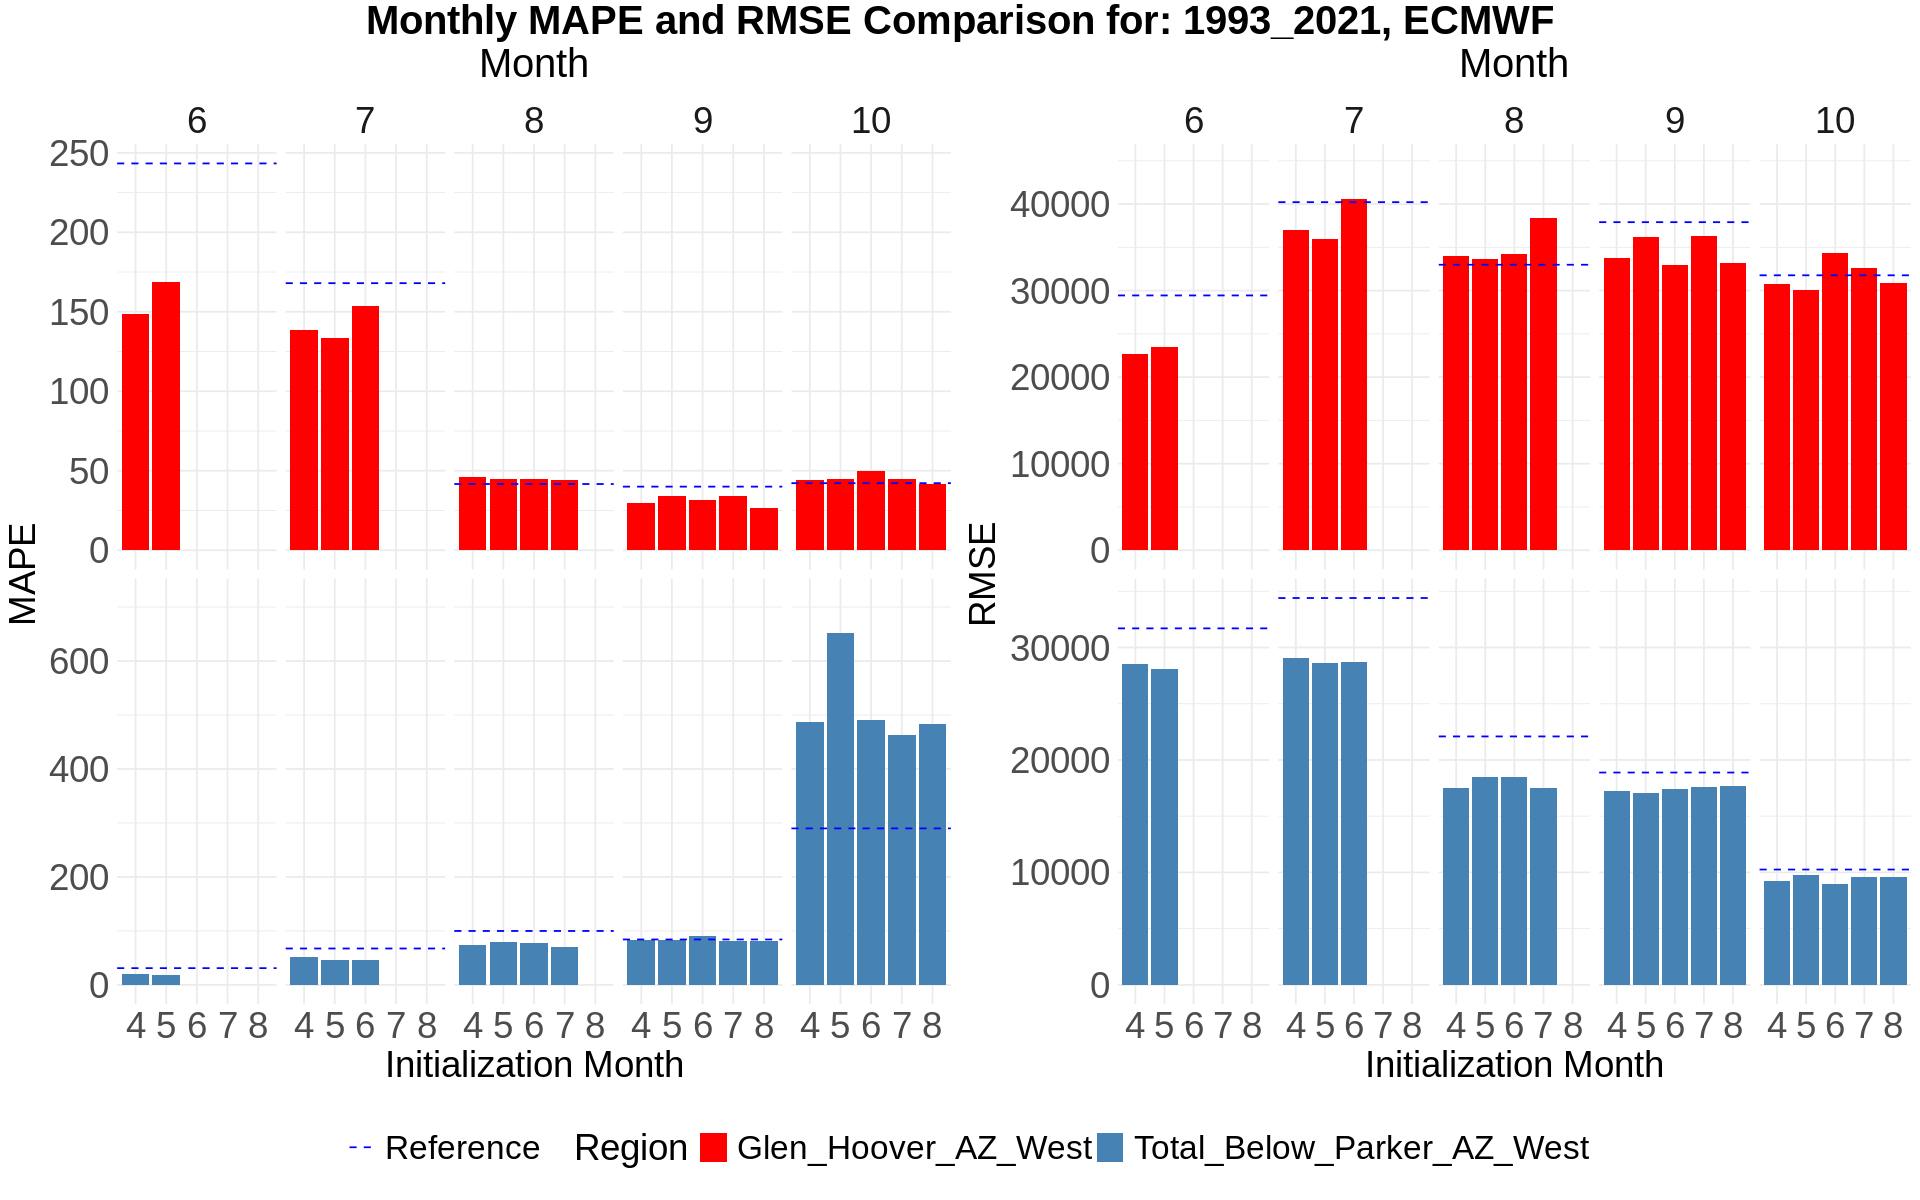

In [ ]:
# Set the metrics to be evaluated
metrics <- c("MAPE", "RMSE")
plot_dir <- paste0("/content/", model_dir, "/plot_output/")

# Create a new column that combines gage and region for the legend
combined_metrics <- combined_metrics %>%
  mutate(Gage_Region_Label = paste(Gage, Region, sep = "_"))

# Get unique gage-region combinations from the dataset
gage_regions <- unique(combined_metrics$Gage_Region_Label)

# Calculate dynamic y-limits for each Gage_Region_Label
y_limits <- combined_metrics %>%
  group_by(Gage_Region_Label) %>%
  summarise(Max_MAPE = max(Monthly_MAPE_pred, na.rm = TRUE),
            Max_RMSE = max(Monthly_RMSE_pred, na.rm = TRUE)) %>%
  mutate(Dynamic_MAPE_Limit = Max_MAPE * 1.1,  # Add 10% buffer
         Dynamic_RMSE_Limit = Max_RMSE * 1.1)

plot_list <- list()

for (metric in metrics) {
  metric_pred <- paste0("Monthly_", metric, "_pred")
  metric_ref <- paste0("Monthly_", metric, "_ref")

  options(repr.plot.width = 16, repr.plot.height = 10)

  p <- ggplot() +
    geom_bar(data = combined_metrics, aes(x = LeadMonth, y = .data[[metric_pred]], fill = Gage_Region_Label),
             stat = "identity", position = position_dodge(width = 0.75), na.rm = TRUE) +
    geom_hline(data = combined_metrics %>% group_by(Gage_Region_Label, Month) %>%
                 summarise(Avg_Ref = mean(.data[[metric_ref]], na.rm = TRUE), .groups = 'drop'),
               aes(yintercept = Avg_Ref, linetype = "Reference"), color = "blue", linewidth = 0.5, na.rm = TRUE) +
    scale_linetype_manual(values = c(Reference = "dashed"), guide = guide_legend(title = "")) +
    facet_grid(Gage_Region_Label ~ Month, scales = "free_y") +
    labs(title = "Month",
         x = "Initialization Month", y = metric, fill = "Region") +
    theme_minimal() +
    theme(plot.title = element_text(size = 24, hjust = 0.5),
          axis.title.x = element_text(size = 22),
          axis.title.y = element_text(size = 22),
          axis.text.x = element_text(size = 22),
          axis.text.y = element_text(size = 22),
          legend.title = element_text(size = 22),
          legend.text = element_text(size = 20),
          strip.text = element_text(size = 22)) +
    theme(axis.ticks.y.right = element_blank(),
          axis.text.y.right = element_blank()) +
    theme(legend.position = "bottom",
          legend.box = "horizontal",
          legend.box.just = "center",
          strip.text.y = element_blank()) +
    # Define colors (you can manually adjust as needed)
    scale_fill_manual(values = c("red", "#4682B4"))  # "#4682B4"  steel blue

  # Dynamically adjust y-limits based on the calculated values for MAPE
  if (metric == "MAPE") {
    # Adjust the y-limits separately for each gage-region
    p <- p + facet_grid(Gage_Region_Label ~ Month, scales = "free_y") +
      geom_blank(data = combined_metrics %>%
                   left_join(y_limits, by = "Gage_Region_Label") %>%
                   filter(.data[[metric_pred]] <= Dynamic_MAPE_Limit),
                 aes(y = Dynamic_MAPE_Limit))
  }

  # Dynamically adjust y-limits based on the calculated values for RMSE
  if (metric == "RMSE") {
    # Adjust the y-limits separately for each gage-region
    p <- p + facet_grid(Gage_Region_Label ~ Month, scales = "free_y") +
      geom_blank(data = combined_metrics %>%
                   left_join(y_limits, by = "Gage_Region_Label") %>%
                   filter(.data[[metric_pred]] <= Dynamic_RMSE_Limit),
                 aes(y = Dynamic_RMSE_Limit))
  }

  plot_list[[metric]] <- p
}

get_legend <- function(myplot) {
  tmp <- ggplot_gtable(ggplot_build(myplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}

combined_plots <- lapply(plot_list, function(p) p + theme(legend.position = "none"))

legend <- get_legend(plot_list[[1]])

combined_plot <- arrangeGrob(
  grobs = c(combined_plots, list(legend)),
  layout_matrix = rbind(c(1, 2), c(3, 3)),
  heights = c(10, 1),
  top = textGrob(
    paste0("Monthly MAPE and RMSE Comparison for: ", year_start_metrics, "_", year_end_metrics, ", ", model_dir),
    gp = gpar(fontsize = 24, fontface = "bold")
  )
)

grid.newpage()
grid.draw(combined_plot)

# Save the combined plot
file_path <- paste0(plot_dir, "Metric_Comparison_Combined.png")
ggsave(file_path, plot = combined_plot, width = 32, height = 16, dpi = 300)

# Figure 8

Note that to set the configurations properly for Figure 8 (look at Step1).



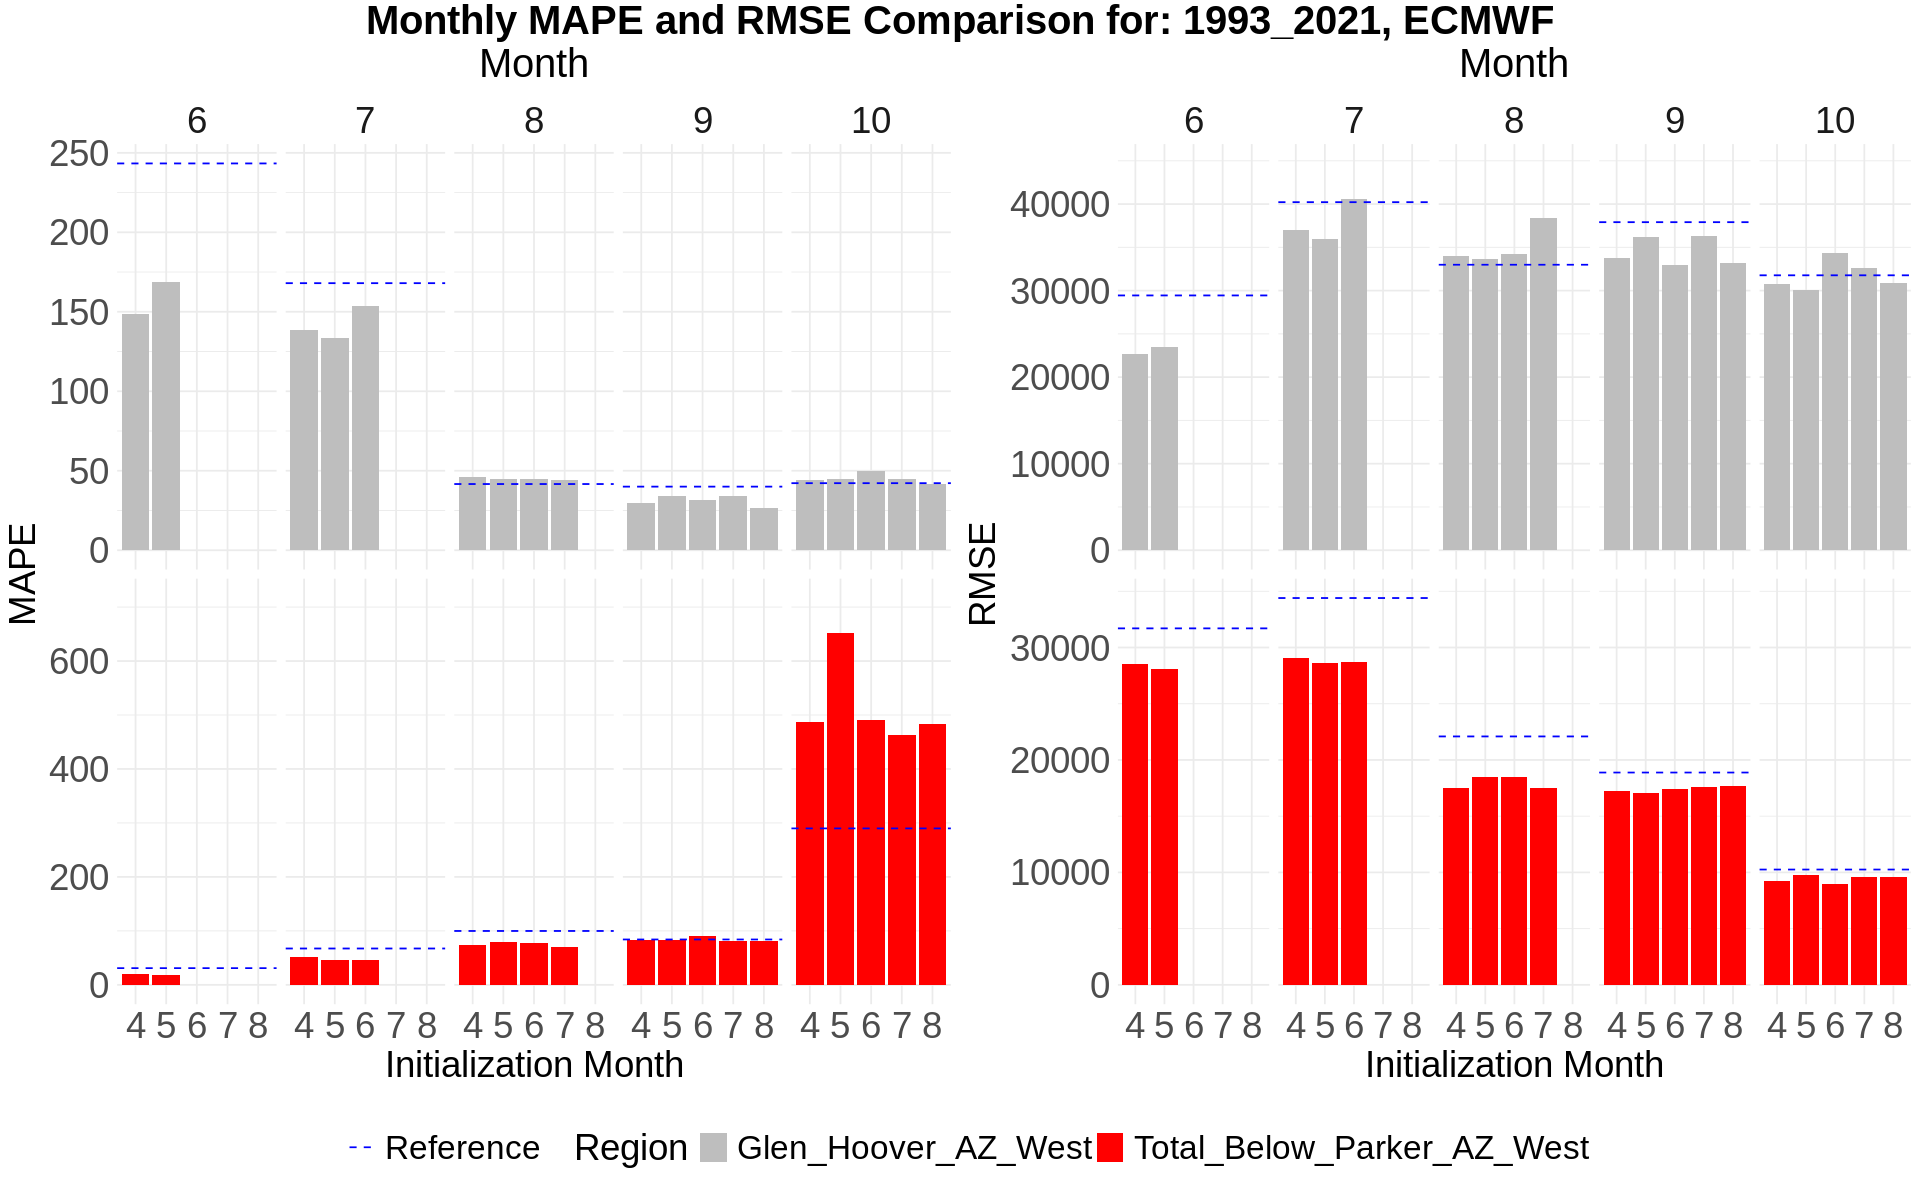

In [ ]:
# Set the metrics to be evaluated
metrics <- c("MAPE", "RMSE")
plot_dir <- paste0("/content/", model_dir, "/plot_output/")

# Create a new column that combines gage and region for the legend
combined_metrics <- combined_metrics %>%
  mutate(Gage_Region_Label = paste(Gage, Region, sep = "_"))

# Get unique gage-region combinations from the dataset
gage_regions <- unique(combined_metrics$Gage_Region_Label)

# Calculate dynamic y-limits for each Gage_Region_Label
y_limits <- combined_metrics %>%
  group_by(Gage_Region_Label) %>%
  summarise(Max_MAPE = max(Monthly_MAPE_pred, na.rm = TRUE),
            Max_RMSE = max(Monthly_RMSE_pred, na.rm = TRUE)) %>%
  mutate(Dynamic_MAPE_Limit = Max_MAPE * 1.1,  # Add 10% buffer
         Dynamic_RMSE_Limit = Max_RMSE * 1.1)

plot_list <- list()

for (metric in metrics) {
  metric_pred <- paste0("Monthly_", metric, "_pred")
  metric_ref <- paste0("Monthly_", metric, "_ref")

  options(repr.plot.width = 16, repr.plot.height = 10)

  p <- ggplot() +
    geom_bar(data = combined_metrics, aes(x = LeadMonth, y = .data[[metric_pred]], fill = Gage_Region_Label),
             stat = "identity", position = position_dodge(width = 0.75), na.rm = TRUE) +
    geom_hline(data = combined_metrics %>% group_by(Gage_Region_Label, Month) %>%
                 summarise(Avg_Ref = mean(.data[[metric_ref]], na.rm = TRUE), .groups = 'drop'),
               aes(yintercept = Avg_Ref, linetype = "Reference"), color = "blue", linewidth = 0.5, na.rm = TRUE) +
    scale_linetype_manual(values = c(Reference = "dashed"), guide = guide_legend(title = "")) +
    facet_grid(Gage_Region_Label ~ Month, scales = "free_y") +
    labs(title = "Month",
         x = "Initialization Month", y = metric, fill = "Region") +
    theme_minimal() +
    theme(plot.title = element_text(size = 24, hjust = 0.5),
          axis.title.x = element_text(size = 22),
          axis.title.y = element_text(size = 22),
          axis.text.x = element_text(size = 22),
          axis.text.y = element_text(size = 22),
          legend.title = element_text(size = 22),
          legend.text = element_text(size = 20),
          strip.text = element_text(size = 22)) +
    theme(axis.ticks.y.right = element_blank(),
          axis.text.y.right = element_blank()) +
    theme(legend.position = "bottom",
          legend.box = "horizontal",
          legend.box.just = "center",
          strip.text.y = element_blank()) +
    # Define colors (you can manually adjust as needed)
    scale_fill_manual(values = c("gray", "red" ))  # "#4682B4"  steel blue, red

  # Dynamically adjust y-limits based on the calculated values for MAPE
  if (metric == "MAPE") {
    # Adjust the y-limits separately for each gage-region
    p <- p + facet_grid(Gage_Region_Label ~ Month, scales = "free_y") +
      geom_blank(data = combined_metrics %>%
                   left_join(y_limits, by = "Gage_Region_Label") %>%
                   filter(.data[[metric_pred]] <= Dynamic_MAPE_Limit),
                 aes(y = Dynamic_MAPE_Limit))
  }

  # Dynamically adjust y-limits based on the calculated values for RMSE
  if (metric == "RMSE") {
    # Adjust the y-limits separately for each gage-region
    p <- p + facet_grid(Gage_Region_Label ~ Month, scales = "free_y") +
      geom_blank(data = combined_metrics %>%
                   left_join(y_limits, by = "Gage_Region_Label") %>%
                   filter(.data[[metric_pred]] <= Dynamic_RMSE_Limit),
                 aes(y = Dynamic_RMSE_Limit))
  }

  plot_list[[metric]] <- p
}

get_legend <- function(myplot) {
  tmp <- ggplot_gtable(ggplot_build(myplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}

combined_plots <- lapply(plot_list, function(p) p + theme(legend.position = "none"))

legend <- get_legend(plot_list[[1]])

combined_plot <- arrangeGrob(
  grobs = c(combined_plots, list(legend)),
  layout_matrix = rbind(c(1, 2), c(3, 3)),
  heights = c(10, 1),
  top = textGrob(
    paste0("Monthly MAPE and RMSE Comparison for: ", year_start_metrics, "_", year_end_metrics, ", ", model_dir),
    gp = gpar(fontsize = 24, fontface = "bold")
  )
)

grid.newpage()
grid.draw(combined_plot)

# Save the combined plot
file_path <- paste0(plot_dir, "Metric_Comparison_Combined.png")
ggsave(file_path, plot = combined_plot, width = 32, height = 16, dpi = 300)

# Figure 13

# Plot of the models metrics comparison
You should run the notebook for three time spans save the outputs in three folders for each model: \
SMYLE_Prein_data : Hindcast WT: 1982-2021 \
SMYLE_1985: Hindcast WT: 1985-2023 \
SMYLE_def: Hindcast WT: 1970-2023

ECMWF_Prein_data : Hindcast WT: 1982-2021 \
ECMWF_1985: Hindcast WT: 1985-2023 \
ECMWF_def: Hindcast WT: 1970-2023

In [ ]:
if (FALSE) {

# Load necessary libraries
library(ggplot2)
library(dplyr)
library(reshape2)
library(gridExtra)
library(grid)

path_prein <- '/content/SMYLE_Prein_data/12.combined_metrics.csv'
path_1985 <- '/content/SMYLE_1985/12.combined_metrics.csv'
path_def <- '/content/SMYLE_def/12.combined_metrics.csv'

data_prein <- read.csv(path_prein)
data_1985 <- read.csv(path_1985)
data_def <- read.csv(path_def)

data_prein$model <- 'Prein.et.al'
data_1985$model <- '1985_2023'
data_def$model <- '1970_2023'

combined_data <- bind_rows(data_prein, data_1985, data_def)

combined_data <- combined_data %>%
  mutate(
    RMSE = Monthly_RMSE_pred,
    MAPE = Monthly_MAPE_pred
  )

gage_regions <- unique(combined_data$Gage_Region)

plot_list <- list()
for (gage_region in gage_regions) {

  data_gage <- combined_data %>% filter(Gage_Region == gage_region)

  metrics <- c("RMSE", "MAPE")  # RMSE first, MAPE second

  for (metric in metrics) {

    p <- ggplot(data_gage) +
      geom_bar(aes(x = as.factor(LeadMonth), y = .data[[metric]], fill = model),
               stat = "identity", position = position_dodge(width = 0.75), na.rm = TRUE) +
      facet_grid(Gage_Region ~ Month, scales = "free_y") +
      labs(title = paste0(gage_region),
           x = "Lead Month", y = paste0(" ", metric), fill = "Search Pool Period") +
      theme_minimal() +
      theme(plot.title = element_text(size = 24, hjust = 0.5),
            axis.title.x = element_text(size = 22),
            axis.title.y = element_text(size = 22),
            axis.text.x = element_text(size = 16),
            axis.text.y = element_text(size = 16),
            legend.title = element_text(size = 18),
            legend.text = element_text(size = 16),
            strip.text = element_text(size = 18),
            axis.ticks.y.right = element_blank(),
            axis.text.y.right = element_blank(),
            legend.position = "bottom",
            legend.box = "horizontal",
            legend.box.just = "center",
            strip.text.y = element_blank()) +
      scale_fill_manual(values = c("Prein.et.al" = "black", "1985_2023" = "blue", "1970_2023" = "red"))

    plot_list[[paste0(gage_region, "_", metric)]] <- p
  }
}

get_legend <- function(myplot) {
  tmp <- ggplot_gtable(ggplot_build(myplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}

combined_plots <- lapply(plot_list, function(p) p + theme(legend.position = "none"))
legend <- get_legend(plot_list[[1]])

combined_plot <- arrangeGrob(
  grobs = c(combined_plots[paste0(gage_regions[1], "_MAPE")], combined_plots[paste0(gage_regions[1], "_RMSE")],
            combined_plots[paste0(gage_regions[2], "_MAPE")], combined_plots[paste0(gage_regions[2], "_RMSE")], list(legend)),
  layout_matrix = rbind(c(1, 2), c(3, 4), c(5, 5)),
  heights = c(10, 10, 1),
  top = textGrob("Comparison of Prediction Errors by Search Pool Size, SMYLE", gp = gpar(fontsize = 24, fontface = "bold"))
)

grid.newpage()
grid.draw(combined_plot)

file_path <- "/content/Metric_Comparison_Combined.png"
ggsave(file_path, plot = combined_plot, width = 16, height = 20, dpi = 300)

}
